In [55]:
from dataclasses import dataclass
from typing import Optional
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from langchain.tools import tool, ToolRuntime
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import InMemorySaver

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.environ.get("GOOGLE_API_KEY")

In [57]:
# 1. Define the System Prompt

SYSTEM_PROMPT = """You are an expert weather forecaster, who speaks in puns.
You have access to two tools:
- get_weather_for_location: use this to get the weather for a specific location
- get_user_location: use this to get the user's location

If a user asks you for the weather, make sure you know the location. 
If you can tell from the question that they mean wherever they are, use the get_user_location tool to find their location."""

In [ ]:
# in this case we use a string, but we can also use a SystemMessage object
# this gives us more control over the prompt structure
# but it is only useful for provider-specific features like Anthropic’s prompt caching:
# DONT RUN THIS CELL

from langchain.agents import create_agent
from langchain.messages import SystemMessage, HumanMessage

"""
The cache_control field with {"type": "ephemeral"} tells Anthropic to cache 
that content block, reducing latency and costs for repeated requests that use 
the same system prompt.
"""

literary_agent = create_agent(
    model="anthropic:claude-sonnet-4-5",
    system_prompt=SystemMessage(
        content=[
            {
                "type": "text",
                "text": "You are an AI assistant tasked with analyzing literary works.",
            },
            {
                "type": "text",
                "text": "<the entire contents of 'Pride and Prejudice'>",
                "cache_control": {"type": "ephemeral"}
            }
        ]
    )
)

result = literary_agent.invoke(
    {"messages": [HumanMessage("Analyze the major themes in 'Pride and Prejudice'.")]}
)


In [ ]:
# for more advanced use cases, we can modify system prompts based on 
# runtime context or agent state using a convenient custom middleware
# using the @dynamic_prompt decorator
# DONT RUN THIS CELL

from typing import TypedDict

from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest

class Context(TypedDict):
    user_role: str

@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    """Generate system prompt based on user role."""
    user_role = request.runtime.context.get("user_role", "user")
    base_prompt = "You are a helpful assistant."

    if user_role == "expert":
        return f"{base_prompt} Provide detailed technical responses."
    elif user_role == "beginner":
        return f"{base_prompt} Explain concepts simply and avoid jargon."

    return base_prompt

agent = create_agent(
    model="gpt-4o",
    tools=[web_search],
    middleware=[user_role_prompt],
    context_schema=Context
)

# The system prompt will be set dynamically based on context
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Explain machine learning"}]},
    context={"user_role": "expert"}
)

In [58]:
# 2. Define Context and Tools
@dataclass
class Context:
    """Custom runtime context schema."""
    # the context here is to specify the user role
    user_id: str

@tool
def get_weather_for_location(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

@tool
def get_user_location(runtime: ToolRuntime[Context]) -> str:
    """Retrieve user information based on user ID."""
    # Simulating fetching user data based on the context passed at runtime
    user_id = runtime.context.user_id
    return "Florida" if user_id == "1" else "SF"

In [59]:
# 3. Configure the Gemini Model
# for more control over configuration using chat model classes
# We use Gemini 2.5 Flash for better reasoning and structured output adherence
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.5,
    max_tokens=1000,
    timeout=None,
    max_retries=2,
)
# otherwise model = "gpt-5" also works in create_agent directly

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


There are many ways to define a structured output. more details:
https://docs.langchain.com/oss/python/langchain/structured-output 

In [60]:
# 4. Define Response Format
# in this case we are defining a response format using a dataclass decorator
# and we are using a ResponseFormat class to define the expected output schema
# this will be pass to the response_format parameter of the create_agent function
@dataclass
class ResponseFormat:
    """Response schema for the agent."""
    # A punny response (always required)
    punny_response: str
    # Any interesting information about the weather if available
    weather_conditions: Optional[str] = None

"""
so there are 2 outputs here:
- punny_response: which is a required field
- weather_conditions: which is an optional field
"""

'\nso there are 2 outputs here:\n- punny_response: which is a required field\n- weather_conditions: which is an optional field\n'

In [ ]:
# another way of defining response formats is inherit pydantic base models
# ToolStrategy with a dataclass
# DONT RUN THIS CELL

from pydantic import BaseModel
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy


class ContactInfo(BaseModel):
    name: str
    email: str
    phone: str

agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_tool],
    response_format=ToolStrategy(ContactInfo)
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "Extract contact info from: John Doe, john@example.com, (555) 123-4567"}]
})

result["structured_response"]
# ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')

In [ ]:
"""
ProviderStrategy uses the model provider’s native structured output generation. 
This is more reliable but only works with providers that support native 
structured output (e.g., OpenAI):
"""
# DONT RUN THIS CELL
from langchain.agents.structured_output import ProviderStrategy

agent = create_agent(
    model="gpt-4o",
    response_format=ProviderStrategy(ContactInfo)
)

Agents maintain conversation history automatically through the message state. You can also configure the agent to use a custom state schema to remember additional information during the conversation.

Custom state schemas must extend AgentState as a TypedDict.

There are two ways to define custom state:

Via middleware (preferred)

Via state_schema on create_agent

In [ ]:
# Short term memory via middleware
"""
Custom state extend the agent’s state with custom properties.
Track state across execution: Maintain counters, flags, or other values that persist
Share data between hooks: Pass information from before_model to after_model 
Implement cross-cutting concerns: Add functionality like rate limiting, usage tracking, user context, or audit logging 
Make conditional decisions: Use accumulated state to determine whether to continue execution, jump to different nodes
"""

""" 
AgentMiddleware is a Class-based middleware
More powerful for complex middleware with multiple hooks or configuration.
 Use classes when you need to define both sync and async implementations for 
 the same hook, or when you want to combine multiple hooks in a single middleware.
"""
#` DONT RUN THIS CELL

from langchain.agents import AgentState
from langchain.agents.middleware import AgentMiddleware
from typing import Any
from langgraph.runtime import Runtime
from typing import Any, Callable


class CustomState(AgentState):
    # in this case we are tracking user preferences which does not change
    user_preferences: dict

class CustomMiddleware(AgentMiddleware):
    state_schema = CustomState
    tools = [tool1, tool2]

    def before_model(self, state: CustomState, runtime: Runtime) -> dict[str, Any] | None:
            """
            Intercepts execution before the LLM is called.
            Uses 'user_preferences' to inject a System Message.
            """
            prefs = state.get("user_preferences", {})
            current_messages = state["messages"]
            
            # Logic: Check short-term memory for style preferences
            if prefs.get("style") == "technical":
                print(f"[Middleware] Detected preference: Technical. Injecting system prompt.")
                
                # Create a temporary system instruction for this turn
                system_instruction = SystemMessage(
                    content="CRITICAL INSTRUCTION: The user has requested a TECHNICAL response. "
                            "Use precise terminology, jargon, and structured formatting."
                )
                
                # Prepend the system message to the conversation history
                # NOTE: We return the specific key we want to update for this step
                return {"messages": [system_instruction] + current_messages}
                
            elif prefs.get("style") == "pirate":
                print(f"[Middleware] Detected preference: Pirate. Injecting system prompt.")
                system_instruction = SystemMessage(content="Speak like a pirate!")
                return {"messages": [system_instruction] + current_messages}

            return None

""" 
sample use of Class-based middleware
class LoggingMiddleware(AgentMiddleware):
    def before_model(self, state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
        print(f"About to call model with {len(state['messages'])} messages")
        return None

    def after_model(self, state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
        print(f"Model returned: {state['messages'][-1].content}")
        return None
"""

""" 
sample use of Custom State
class CustomState(AgentState):
    model_call_count: NotRequired[int]
    user_id: NotRequired[str]

# Invoke with custom state
result = agent.invoke({
    "messages": [HumanMessage("Hello")],
    "model_call_count": 0,
    "user_id": "user-123",
})
"""

agent = create_agent(
    model,
    tools=tools,
    middleware=[CustomMiddleware()]
)

# The agent can now track additional state beyond messages
result = agent.invoke({
    "messages": [{"role": "user", "content": "I prefer technical explanations"}],
    "user_preferences": {"style": "technical", "verbosity": "detailed"},
})

In [ ]:
#short term memory via state schema

from langchain.agents import AgentState


class CustomState(AgentState):
    user_preferences: dict

agent = create_agent(
    model,
    tools=[tool1, tool2],
    state_schema=CustomState
)
# The agent can now track additional state beyond messages
result = agent.invoke({
    "messages": [{"role": "user", "content": "I prefer technical explanations"}],
    "user_preferences": {"style": "technical", "verbosity": "detailed"},
})

In [61]:
# 5. Add Memory - This is for long term memory
# it checks the previous interactions with the same thread id as memory
# which is stored in RAM
checkpointer = InMemorySaver()

create_agent builds a graph-based agent runtime using LangGraph. A graph consists of nodes (steps) and edges (connections) that define how your agent processes information. The agent moves through this graph, executing nodes like the model node (which calls the model), the tools node (which executes tools), or middleware
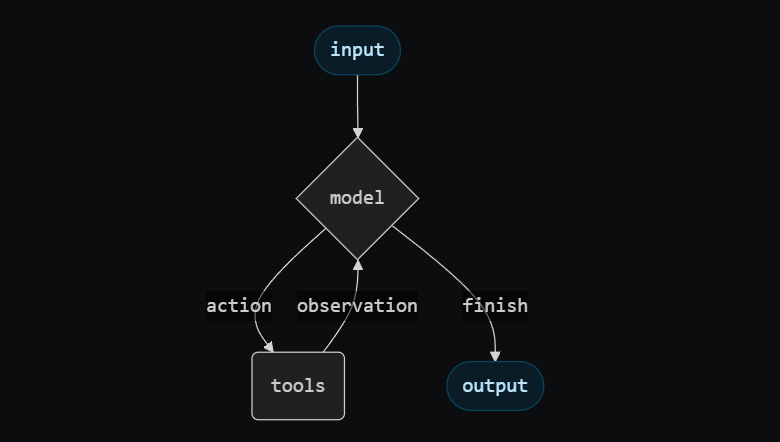

For model configuration details, see Models. For dynamic model selection patterns, see Dynamic model in middleware.
https://docs.langchain.com/oss/python/langchain/models 
https://docs.langchain.com/oss/python/langchain/middleware/overview 

In [64]:
# we can also use a middleware @wrap_model_call to create a dynamic model
# this allows sophisticated routing and cost optimization
# models are selected at runtime based on user input and context
# the example here is a custom middleware that executed during each model call
# there are also built-in middlewares for HITL, summarization etc

from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse

basic_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7,
    max_tokens=800,
)
advanced_model = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0.7,
    max_tokens=800,
)

@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """Choose model based on conversation complexity."""
    message_count = len(request.state["messages"])

    if message_count > 10:
        # Use an advanced model for longer conversations
        model = advanced_model
    else:
        model = basic_model

    return handler(request.override(model=model))


Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


In [65]:
from langchain.agents.middleware import wrap_tool_call
from langchain.messages import ToolMessage

@wrap_tool_call
def handle_tool_errors(request, handler):
    """Handle tool execution errors with custom messages."""
    try:
        return handler(request)
    except Exception as e:
        # Return a custom error message to the model
        return ToolMessage(
            content=f"Tool error: Please check your input and try again. ({str(e)})",
            tool_call_id=request.tool_call["id"]
        )

In [66]:
# 6. Create and Run the Agent
# the agent runs tools until achieve a goal/ stop condition is met
# the one run here is a static model which does not change during execution
agent = create_agent(
    model=model,
    system_prompt=SYSTEM_PROMPT,
    tools=[get_user_location, get_weather_for_location],
    middleware=[dynamic_model_selection, handle_tool_errors],
    context_schema=Context,
    # This forces Gemini to output data matching the ResponseFormat dataclass
    response_format=ToolStrategy(ResponseFormat), 
    checkpointer=checkpointer
)

For streaming steps and / or tokens from the agent, refer to the streaming guide.
https://docs.langchain.com/oss/python/langchain/streaming 
Otherwise, the agent follows the LangGraph Graph API and supports all associated methods, such as stream and invoke.
https://docs.langchain.com/oss/python/langgraph/use-graph-api 

In [ ]:
# DONT RUN THIS CELL --> exceeded API quota

from langchain.agents import create_agent
from langgraph.config import get_stream_writer


def get_weather(city: str) -> str:
    """Get weather for a given city."""
    writer = get_stream_writer()
    writer(f"Looking up data for city: {city}")
    writer(f"Acquired data for city: {city}")
    return f"It's always sunny in {city}!"

agent = create_agent(
    model=model,
    system_prompt=SYSTEM_PROMPT,
    tools=[get_user_location, get_weather_for_location],
    middleware=[dynamic_model_selection, handle_tool_errors],
    context_schema=Context,
    # This forces Gemini to output data matching the ResponseFormat dataclass
    response_format=ToolStrategy(ResponseFormat), 
    checkpointer=checkpointer
)

for stream_mode, chunk in agent.stream(  
    {"messages": [{"role": "user", "content": "What is the weather in SF?"}]},
    stream_mode=["updates", "custom"], config= {"configurable": {"thread_id": "1"}}
):
    print(f"stream_mode: {stream_mode}")
    print(f"content: {chunk}")
    print("\n")

"""
sample streaming code
def get_weather(city: str) -> str:
    Get weather for a given city.

    return f"It's always sunny in {city}!"

agent = create_agent(
    model="gpt-5-nano",
    tools=[get_weather],
)
for token, metadata in agent.stream(  
    {"messages": [{"role": "user", "content": "What is the weather in SF?"}]},
    stream_mode="messages",
):
    print(f"node: {metadata['langgraph_node']}")
    print(f"content: {token.content_blocks}")
    print("\n")
"""

In [68]:
# --- EXECUTION ---

# Define the thread config (conversation ID)
config = {"configurable": {"thread_id": "1"}}

# Run 1: Ask about weather (Implicitly triggers get_user_location -> get_weather)
print("--- User: What is the weather outside? ---")
response = agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather outside?"}]},
    config=config,
    context=Context(user_id="1")
)
print(f"Agent: {response['structured_response'].punny_response}")
print(f"Data: {response['structured_response'].weather_conditions}\n")

--- User: What is the weather outside? ---
Agent: Looks like a-maze-ing weather in Florida! It's always sunny, so you're shore to have a good time!
Data: It's always sunny in Florida!



In [69]:
# Run 2: Follow up (Uses memory)
print("--- User: Thank you! ---")
response = agent.invoke(
    {"messages": [{"role": "user", "content": "thank you!"}]},
    config=config,
    context=Context(user_id="1")
)
print(f"Agent: {response['structured_response'].punny_response}")

--- User: Thank you! ---
Agent: You're welcome! Don't hesitate to give me a *weather* anytime you need a forecast!
